In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd

path = '/content/drive/MyDrive/QA_analysis_HybrRAG_Mistral_JPMC_all_original_.xlsx'

if os.path.exists(path):
    try:
        # Read the Excel file into a pandas DataFrame
        df = pd.read_excel(path)

        # Convert the DataFrame to a CSV string
        csv_data = df.to_csv(index=False)  # Set index=False to avoid writing row indices

        # Define the output CSV file path
        csv_file_path = '/content/drive/MyDrive/QA_analysis_HybrRAG_Mistral_JPMC_all_original_.csv'

        # Write the CSV data to a file
        with open(csv_file_path, 'w') as f:
            f.write(csv_data)

        print(f"Excel file successfully converted to CSV at: {csv_file_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

else:
    print(f"File not found at {path}")

Excel file successfully converted to CSV at: /content/drive/MyDrive/QA_analysis_HybrRAG_Mistral_JPMC_all_original_.csv


In [ ]:
df

,doc_num,quarter,Q_num,Q_who,question,A_who,answer,retrieved_text,evaluation,evaluation_clean
0,0,2Q24 FINANCIAL RESULTS,1,"Steven Chubak, Analyst, Wolfe Research LLC","Hi. Good morning, Jeremy. \n","Jeremy Barnum, Chief Financial Officer, JPMorg...","Good morning, Steve. \n",MANAGEMENT DISCUSSION SECTION \n ... \n\nOper...,[{'generated_text': '\nYou are an expert at an...,Partially-answered
1,0,2Q24 FINANCIAL RESULTS,2,"Steven Chubak, Analyst, Wolfe Research LLC","So, wanted to start off with a question on cap...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Right. Okay. Thanks, Steve. And actually, befo...",On to balance sheet and capital on page 3. We ...,"[{'generated_text': ""\nYou are an expert at an...",Well-answered
2,0,2Q24 FINANCIAL RESULTS,5,"Saul Martinez, Analyst, HSBC Securities (USA),...","Hi, good morning. Thanks for taking my questio...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Yeah. So, I'm not going to comment about any c...",On to balance sheet and capital on page 3. We ...,"[{'generated_text': ""\nYou are an expert at an...",Partially-answered
3,0,2Q24 FINANCIAL RESULTS,6,"Saul Martinez, Analyst, HSBC Securities (USA),...","Okay, got it. That's helpful. Just following u...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Sure. Yeah. I mean, I would direct you to read...","were up 50% year-on-year, and we ranked number...","[{'generated_text': ""\nYou are an expert at an...",Partially-answered
4,0,2Q24 FINANCIAL RESULTS,7,"Saul Martinez, Analyst, HSBC Securities (USA),...","Okay, great. Thanks a lot. \n","Jeremy Barnum, Chief Financial Officer, JPMorg...","Thanks, Saul. \n...","To finish up, we have the outlook on page 8. O...","[{'generated_text': ""\nYou are an expert at an...",U/A
...,...,...,...,...,...,...,...,...,...,...
68,2,4Q24 FINANCIAL RESULTS,21,"Ebrahim H. Poonawala, Analyst, BofA Securities...",Good morning. I guess just two questions. In t...,"Jeremy Barnum, Chief Financial Officer, JPMorg...","Oh, I see where your question is. That took me...","In Commercial Banking, Middle Market loans wer...","[{'generated_text': ""\nYou are an expert at an...",Partially-answered
69,2,4Q24 FINANCIAL RESULTS,22,"Ebrahim H. Poonawala, Analyst, BofA Securities...",And I guess – thanks for that. Just sticking w...,"Jeremy Barnum, Chief Financial Officer, JPMorg...","Yeah. I think the conventional wisdom on QT, a...","loan growth again this year, but below the 12%...","[{'generated_text': ""\nYou are an expert at an...",Well-answered
70,2,4Q24 FINANCIAL RESULTS,24,"Gerard Cassidy, Analyst, RBC Capital Markets LLC","Hi, Jeremy. Hi, Jamie. Jeremy...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Good morning, Gerard. \n","With that, I'll turn it over to Jamie before w...","[{'generated_text': ""\nYou are an expert at an...",U/A
71,2,4Q24 FINANCIAL RESULTS,25,"Gerard Cassidy, Analyst, RBC Capital Markets LLC",...you mentioned in your comments about the ov...,"Jeremy Barnum, Chief Financial Officer, JPMorg...","That's fascinating, Gerard. I’ll have to take ...","loan growth again this year, but below the 12%...","[{'generated_text': ""\nYou are an expert at an...",Partially-answered


In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline, AutoTokenizer

In [ ]:
import numpy as np
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Load tokenizer and sentiment analysis pipeline
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
classifier = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
# Function to chunk text into max 512-token pieces
def chunk_text(text, max_tokens=512, overlap_ratio=0.1):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    if len(tokens) <= max_tokens:
        return [text]  # Return as is if within limit

    # Convert back to text using sentence tokenization
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []

    token_count = 0
    for sentence in sentences:
        sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
        if token_count + len(sentence_tokens) > max_tokens:
            chunks.append(" ".join(current_chunk))
            current_chunk = current_chunk[-int(len(current_chunk) * overlap_ratio):]  # Overlap
            token_count = sum(len(tokenizer.encode(s, add_special_tokens=False)) for s in current_chunk)

        current_chunk.append(sentence)
        token_count += len(sentence_tokens)

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [ ]:
# Function to compute sentiment score for chunks and aggregate
def analyze_sentiment(text):
    chunks = chunk_text(text)
    sentiment_scores = []
    sentiment_labels = []

    for chunk in chunks:
        result = classifier(chunk)[0]
        sentiment_scores.append(result["score"])
        sentiment_labels.append(result["label"])

    # Aggregation
    avg_score = np.mean(sentiment_scores)  # Average sentiment score
    final_label = max(set(sentiment_labels), key=sentiment_labels.count)  # Majority vote for final sentiment

    return final_label, avg_score

In [ ]:
# Iterate through the DataFrame and perform sentiment analysis
for index, row in df.iterrows():
    try:
        # Process Question
        question_label, question_score = analyze_sentiment(row['question'])
        df.at[index, 'question_sentiment'] = question_label
        df.at[index, 'question_sentiment_score'] = question_score

        # Process Answer
        answer_label, answer_score = analyze_sentiment(row['answer'])
        df.at[index, 'answer_sentiment'] = answer_label
        df.at[index, 'answer_sentiment_score'] = answer_score

    except Exception as e:
        print(f"Error processing row {index}: {e}")
        df.at[index, 'question_sentiment'] = "Error"
        df.at[index, 'question_sentiment_score'] = -1
        df.at[index, 'answer_sentiment'] = "Error"
        df.at[index, 'answer_sentiment_score'] = -1

print(df.head())

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

   doc_num                   quarter  Q_num  \
0        0  2Q24 FINANCIAL RESULTS        1   
1        0  2Q24 FINANCIAL RESULTS        2   
2        0  2Q24 FINANCIAL RESULTS        5   
3        0  2Q24 FINANCIAL RESULTS        6   
4        0  2Q24 FINANCIAL RESULTS        7   

                                               Q_who  \
0         Steven Chubak, Analyst, Wolfe Research LLC   
1         Steven Chubak, Analyst, Wolfe Research LLC   
2  Saul Martinez, Analyst, HSBC Securities (USA),...   
3  Saul Martinez, Analyst, HSBC Securities (USA),...   
4  Saul Martinez, Analyst, HSBC Securities (USA),...   

                                            question  \
0                      Hi. Good morning, Jeremy. \n    
1  So, wanted to start off with a question on cap...   
2  Hi, good morning. Thanks for taking my questio...   
3  Okay, got it. That's helpful. Just following u...   
4                     Okay, great. Thanks a lot. \n    

                                           

In [ ]:
df

,doc_num,quarter,Q_num,Q_who,question,A_who,answer,retrieved_text,evaluation,evaluation_clean,question_sentiment,question_sentiment_score,answer_sentiment,answer_sentiment_score
0,0,2Q24 FINANCIAL RESULTS,1,"Steven Chubak, Analyst, Wolfe Research LLC","Hi. Good morning, Jeremy. \n","Jeremy Barnum, Chief Financial Officer, JPMorg...","Good morning, Steve. \n",MANAGEMENT DISCUSSION SECTION \n ... \n\nOper...,[{'generated_text': '\nYou are an expert at an...,Partially-answered,Neutral,0.806157,Neutral,0.892973
1,0,2Q24 FINANCIAL RESULTS,2,"Steven Chubak, Analyst, Wolfe Research LLC","So, wanted to start off with a question on cap...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Right. Okay. Thanks, Steve. And actually, befo...",On to balance sheet and capital on page 3. We ...,"[{'generated_text': ""\nYou are an expert at an...",Well-answered,Neutral,0.991587,Positive,0.999845
2,0,2Q24 FINANCIAL RESULTS,5,"Saul Martinez, Analyst, HSBC Securities (USA),...","Hi, good morning. Thanks for taking my questio...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Yeah. So, I'm not going to comment about any c...",On to balance sheet and capital on page 3. We ...,"[{'generated_text': ""\nYou are an expert at an...",Partially-answered,Neutral,0.998947,Neutral,0.998237
3,0,2Q24 FINANCIAL RESULTS,6,"Saul Martinez, Analyst, HSBC Securities (USA),...","Okay, got it. That's helpful. Just following u...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Sure. Yeah. I mean, I would direct you to read...","were up 50% year-on-year, and we ranked number...","[{'generated_text': ""\nYou are an expert at an...",Partially-answered,Neutral,0.999782,Neutral,0.998290
4,0,2Q24 FINANCIAL RESULTS,7,"Saul Martinez, Analyst, HSBC Securities (USA),...","Okay, great. Thanks a lot. \n","Jeremy Barnum, Chief Financial Officer, JPMorg...","Thanks, Saul. \n...","To finish up, we have the outlook on page 8. O...","[{'generated_text': ""\nYou are an expert at an...",U/A,Neutral,0.929473,Neutral,0.962454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2,4Q24 FINANCIAL RESULTS,21,"Ebrahim H. Poonawala, Analyst, BofA Securities...",Good morning. I guess just two questions. In t...,"Jeremy Barnum, Chief Financial Officer, JPMorg...","Oh, I see where your question is. That took me...","In Commercial Banking, Middle Market loans wer...","[{'generated_text': ""\nYou are an expert at an...",Partially-answered,Negative,0.964214,Neutral,0.958386
69,2,4Q24 FINANCIAL RESULTS,22,"Ebrahim H. Poonawala, Analyst, BofA Securities...",And I guess – thanks for that. Just sticking w...,"Jeremy Barnum, Chief Financial Officer, JPMorg...","Yeah. I think the conventional wisdom on QT, a...","loan growth again this year, but below the 12%...","[{'generated_text': ""\nYou are an expert at an...",Well-answered,Neutral,0.984475,Neutral,0.999874
70,2,4Q24 FINANCIAL RESULTS,24,"Gerard Cassidy, Analyst, RBC Capital Markets LLC","Hi, Jeremy. Hi, Jamie. Jeremy...","Jeremy Barnum, Chief Financial Officer, JPMorg...","Good morning, Gerard. \n","With that, I'll turn it over to Jamie before w...","[{'generated_text': ""\nYou are an expert at an...",U/A,Neutral,0.845899,Neutral,0.921654
71,2,4Q24 FINANCIAL RESULTS,25,"Gerard Cassidy, Analyst, RBC Capital Markets LLC",...you mentioned in your comments about the ov...,"Jeremy Barnum, Chief Financial Officer, JPMorg...","That's fascinating, Gerard. I’ll have to take ...","loan growth again this year, but below the 12%...","[{'generated_text': ""\nYou are an expert at an...",Partially-answered,Positive,0.786554,Positive,0.558219


In [ ]:
# prompt: convert df into xlsx file

# Convert the DataFrame to an xlsx file
output_xlsx_path = '/content/drive/MyDrive/QA_analysis_HybrRAG_Mistral_JPMC_all_original_with_sentiment_analysis.xlsx'
df.to_excel(output_xlsx_path, index=False)  # Set index=False to avoid writing row indices

print(f"DataFrame successfully converted to xlsx at: {output_xlsx_path}")


DataFrame successfully converted to xlsx at: /content/drive/MyDrive/QA_analysis_HybrRAG_Mistral_JPMC_all_original_with_sentiment_analysis.xlsx


In [ ]:
# prompt: count the different results from the question_sentiment and answer_sentiment columns in df

# Count different results in 'question_sentiment' and 'answer_sentiment' columns
question_sentiment_counts = df['question_sentiment'].value_counts()
answer_sentiment_counts = df['answer_sentiment'].value_counts()

print("Question Sentiment Counts:\n", question_sentiment_counts)
print("\nAnswer Sentiment Counts:\n", answer_sentiment_counts)


Question Sentiment Counts:
 question_sentiment
Neutral     66
Negative     4
Positive     3
Name: count, dtype: int64

Answer Sentiment Counts:
 answer_sentiment
Neutral     50
Positive    18
Negative     5
Name: count, dtype: int64


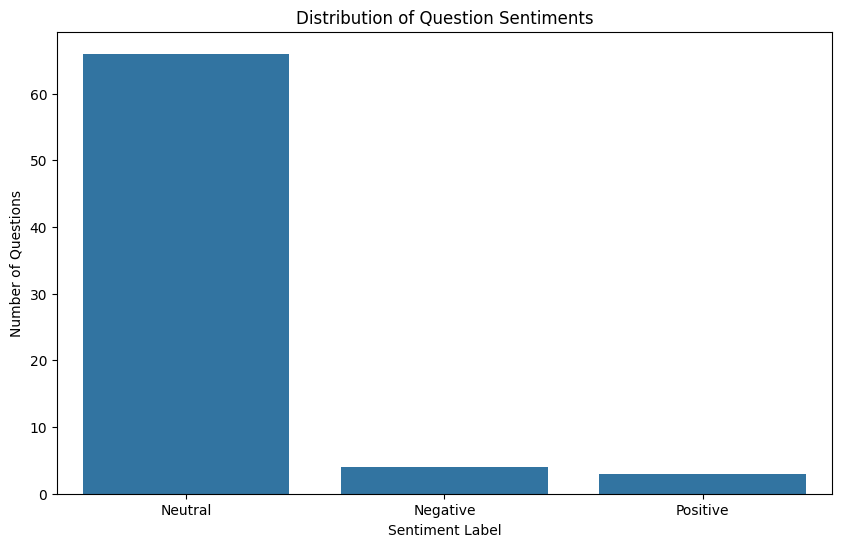

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment label
sentiment_counts = df['question_sentiment'].value_counts()

# Create the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribution of Question Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Questions')
plt.show()


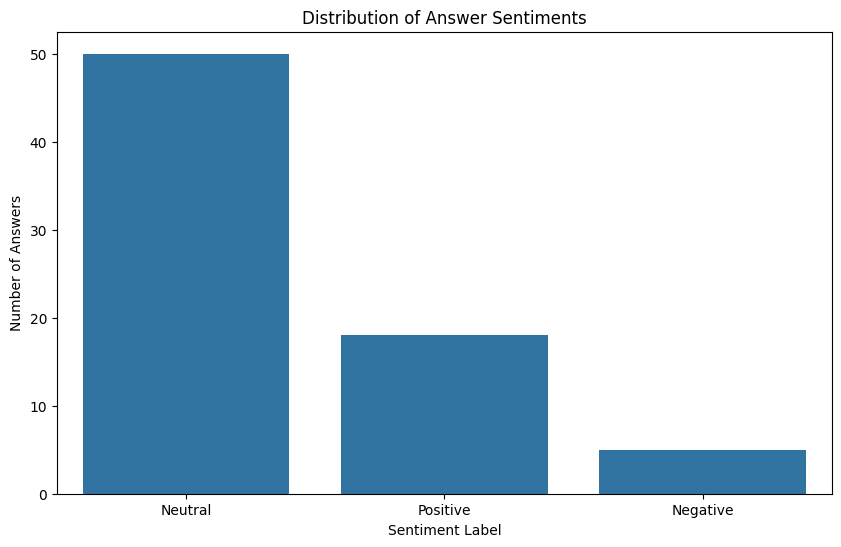

In [ ]:
# Count the occurrences of each sentiment label for answers
sentiment_counts_answer = df['answer_sentiment'].value_counts()

# Create the bar chart for answer sentiments
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts_answer.index, y=sentiment_counts_answer.values)
plt.title('Distribution of Answer Sentiments')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Answers')
plt.show()
